In [1]:
import os
import cv2
import sys
import matplotlib.pyplot as plt
import glob
import itertools
import random
import numpy as np
import torch
import time
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
import torchvision.transforms as transforms
from PIL import Image
import torch.nn.functional as F
from model import *

c:\Users\Eachann\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
batch_size = 3
lr=0.0002#2e-6 to 2e-8
num_epoch = 10
decay_epochs = 0
roots = 'data/uki'
dataname = 'uki'

In [3]:
def remove_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        #print(filename)
        img = plt.imread(os.path.join(folder,filename))
        images.append(img)
        if len(img.shape)!=3:
            print(folder+filename,img.shape)
            os.remove(folder+'/'+filename)
            print('delete W&B image',folder+'/'+filename)
    img_size = img.shape[1]
    return img_size
direc = 'data/horse2zebra/train/B'
img_shape = remove_images_from_folder(direc)
#print(len(imgs),img_shape)
#print([i.shape for i in imgs if i.shape!=(256,256,3)])

In [4]:
class Dataset(Dataset):
    def __init__(self, root, transform=None, unaligned=False, mode="train"):
        self.f_A = sorted(glob.glob(os.path.join(root, f"{mode}/A") + "/*.*"))
        #print(self._A)
        self.f_B = sorted(glob.glob(os.path.join(root, f"{mode}/B") + "/*.*"))
        self.transform = transform
        self.unaligned = unaligned

    def __getitem__(self, index):
        A = self.transform(Image.open(self.f_A[index % len(self.f_A)]))

        if self.unaligned:
            B = self.transform(Image.open(self.f_B[random.randint(0, len(self.f_B) - 1)]))
        else:
            B = self.transform(Image.open(self.f_B[index % len(self.f_B)]))

        return {"A": A, "B": B}

    def __len__(self):
        return max(len(self.f_A), len(self.f_B))

In [5]:
dataset = Dataset(root=roots,
                       transform=transforms.Compose([
                           transforms.Resize(int(img_shape * 1.12), transforms.InterpolationMode.BICUBIC),
                           transforms.RandomCrop(img_shape),
                           transforms.RandomHorizontalFlip(),
                           transforms.ToTensor(),
                           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                       ]),
                           unaligned=True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

In [6]:
random.seed(random.randint(1, 10000))
torch.manual_seed(random.randint(1, 10000))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()
print(device)

cuda:0


In [7]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.zeros_(m.bias)


In [8]:
netG_A2B = Generator().to(device)
netG_B2A = Generator().to(device)
netD_A = Discriminator().to(device)
netD_B = Discriminator().to(device)

netG_A2B.apply(weights_init)
netG_B2A.apply(weights_init)
netD_A.apply(weights_init)
netD_B.apply(weights_init)
print("init finish")

init finish


In [9]:
def wgan_loss_cycle(output, target):
    loss = torch.abs(torch.mean(output*target))
    return loss
def wgan_loss_iden(output, target):
    loss = torch.abs(torch.mean(output*target))
    return loss
#cycle_loss = torch.nn.L1Loss().to(device)
#iden_loss = torch.nn.L1Loss().to(device)
adv_loss = torch.nn.MSELoss().to(device)
optimizer_G = torch.optim.Adam(itertools.chain(netG_A2B.parameters(), netG_B2A.parameters()),
lr=lr, betas=(0.5, 0.999))
optimizer_D_A = torch.optim.Adam(netD_A.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D_B = torch.optim.Adam(netD_B.parameters(), lr=lr, betas=(0.5, 0.999))
print('Optimizer and loss')


Optimizer and loss


In [10]:
class DecayLR:
    def __init__(self, epochs,decay_epochs):
        assert (epochs - decay_epochs> 0)
        self.epochs = epochs
        self.decay_epochs = decay_epochs
    def step(self, epoch):
        return 1.0 - max(0, epoch  - self.decay_epochs) / (
                self.epochs - self.decay_epochs)


In [11]:
class ReplayBuffer:
    def __init__(self, max_size=50):
        assert (max_size > 0), "Empty buffer or trying to create a black hole. Be careful."
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0, 1) > 0.5:
                    i = random.randint(0, self.max_size - 1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return torch.cat(to_return)

In [12]:
lr_lambda = DecayLR(num_epoch,decay_epochs).step
lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=lr_lambda)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=lr_lambda)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=lr_lambda)

In [13]:
g_losses = []
d_losses = []
identity_losses = []
gan_losses = []
cycle_losses = []
fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()

In [14]:
for epoch in range(num_epoch):
    t1 = time.time()
    progress = tqdm(enumerate(dataloader))
    for idx,imgs in progress:
        #Get data
        real_A = imgs["A"].to(device)
        real_B = imgs["B"].to(device)
        batch_size_real = real_A.shape[0]
        real_label = torch.ones(batch_size_real,1).type(torch.float32).to(device)
        fake_label = torch.zeros(batch_size_real,1).type(torch.float32).to(device)
        # Zero Generator grad
        optimizer_G.zero_grad()
        ########## Identity loss
        identity_image_A = netG_B2A(real_A)
        loss_identity_A = wgan_loss_iden(identity_image_A, real_A) * 5.0
        identity_image_B = netG_A2B(real_B)
        loss_identity_B = wgan_loss_iden(identity_image_B, real_B) * 5.0

        ######### GAN loss
        fake_image_A = netG_B2A(real_B)
        fake_output_A = netD_A(fake_image_A)
        loss_GAN_B2A = adv_loss(fake_output_A, real_label)
        fake_image_B = netG_A2B(real_A)
        fake_output_B = netD_B(fake_image_B)
        loss_GAN_A2B = adv_loss(fake_output_B, real_label)

        ###############Cycle loss
        r_image_A = netG_B2A(fake_image_B)
        loss_cycle_ABA = wgan_loss_cycle(r_image_A, real_A) * 10.0

        r_image_B = netG_A2B(fake_image_A)
        loss_cycle_BAB = wgan_loss_cycle(r_image_B, real_B) * 10.0

        # Combined loss
        errG = loss_identity_A + loss_identity_B + loss_GAN_A2B + loss_GAN_B2A + loss_cycle_ABA + loss_cycle_BAB

        # Calculate gradients for G_A and G_B
        errG.backward()
        # Update G_A and G_B's weights
        optimizer_G.step()
        ######################## Discriminator A
        optimizer_D_A.zero_grad()
        real_output_A = netD_A(real_A)
        errD_real_A = adv_loss(real_output_A, real_label)

        fake_image_A = fake_A_buffer.push_and_pop(fake_image_A)
        fake_output_A = netD_A(fake_image_A.detach())
        errD_fake_A = adv_loss(fake_output_A, fake_label)

        errD_A = (errD_real_A + errD_fake_A) / 2

        errD_A.backward()
        optimizer_D_A.step()

        ######################## Discriminator B
        optimizer_D_B.zero_grad()

        real_output_B = netD_B(real_B)
        errD_real_B = adv_loss(real_output_B, real_label)

        fake_image_B = fake_B_buffer.push_and_pop(fake_image_B)
        fake_output_B = netD_B(fake_image_B.detach())
        errD_fake_B = adv_loss(fake_output_B, fake_label)

        errD_B = (errD_real_B + errD_fake_B) / 2

        errD_B.backward()
        optimizer_D_B.step()
        with torch.no_grad():
            d_losses += [(errD_A + errD_B).item()]
            g_losses += [errG.item()]
            identity_losses += [(loss_identity_A + loss_identity_B).item()]
            gan_losses += [(loss_GAN_A2B + loss_GAN_B2A).item()]
            cycle_losses += [(loss_cycle_ABA + loss_cycle_BAB).item()]
        progress.set_description(
            f"[{epoch}/{num_epoch - 1}][{idx}/{len(dataloader) - 1}] "
            f"Loss_D: {(errD_A + errD_B).item():.4f} "
            f"Loss_G: {errG.item():.4f} "
            f"Loss_G_identity: {(loss_identity_A + loss_identity_B).item():.4f} "
            f"loss_G_GAN: {(loss_GAN_A2B + loss_GAN_B2A).item():.4f} "
            f"loss_G_cycle: {(loss_cycle_ABA + loss_cycle_BAB).item():.4f}"
            f'time{time.time()-t1}')
            
     # do check pointing
    if epoch%10 == 10:
        torch.save(netG_A2B.state_dict(), f"weights/{dataset}/netG_A2B_epoch_{epoch}.pth")
        torch.save(netG_B2A.state_dict(), f"weights/{dataset}/netG_B2A_epoch_{epoch}.pth")
        torch.save(netD_A.state_dict(), f"weights/{dataset}/netD_A_epoch_{epoch}.pth")
        torch.save(netD_B.state_dict(), f"weights/{dataset}/netD_B_epoch_{epoch}.pth")
# Update learning rates
    lr_scheduler_G.step()
    lr_scheduler_D_A.step()
    lr_scheduler_D_B.step()
np.save('g_losses.npy',g_losses)
np.save('d_losses.npy',d_losses)
np.save('identity_losses.npy',identity_losses)
np.save('gan_losses.npy',gan_losses)
np.save('cycle_losses.npy',cycle_losses)
# save last check pointing
torch.save(netG_A2B.state_dict(), f"weights/{dataname}/netG_A2B.pth")
torch.save(netG_B2A.state_dict(), f"weights/{dataname}/netG_B2A.pth")
torch.save(netD_A.state_dict(), f"weights/{dataname}/netD_A.pth")
torch.save(netD_B.state_dict(), f"weights/{dataname}/netD_B.pth")


[0/9][1066/1066] Loss_D: 0.2094 Loss_G: 1.9244 Loss_G_identity: 0.1542 loss_G_GAN: 1.5997 loss_G_cycle: 0.1705time564.2075524330139: : 1067it [09:24,  1.89it/s]
[1/9][1066/1066] Loss_D: 0.1986 Loss_G: 1.7894 Loss_G_identity: 0.3649 loss_G_GAN: 0.7963 loss_G_cycle: 0.6282time518.8833165168762: : 1067it [08:38,  2.06it/s] 
[2/9][1066/1066] Loss_D: 0.4324 Loss_G: 2.3046 Loss_G_identity: 0.1492 loss_G_GAN: 1.8039 loss_G_cycle: 0.3514time516.4303095340729: : 1067it [08:36,  2.07it/s] 
[3/9][1066/1066] Loss_D: 0.2092 Loss_G: 1.8169 Loss_G_identity: 0.0979 loss_G_GAN: 1.5619 loss_G_cycle: 0.1570time514.2021462917328: : 1067it [08:34,  2.08it/s] 
[4/9][1066/1066] Loss_D: 0.1995 Loss_G: 1.4995 Loss_G_identity: 0.1391 loss_G_GAN: 0.7921 loss_G_cycle: 0.5683time513.6677587032318: : 1067it [08:33,  2.08it/s] 
[5/9][1066/1066] Loss_D: 0.1077 Loss_G: 1.7369 Loss_G_identity: 0.3604 loss_G_GAN: 0.9605 loss_G_cycle: 0.4160time513.6935179233551: : 1067it [08:33,  2.08it/s] 
[6/9][1066/1066] Loss_D: 0.09

OSError: [Errno 22] Invalid argument: 'weights/<__main__.Dataset object at 0x000001B242C0FCD0>/netG_A2B.pth'

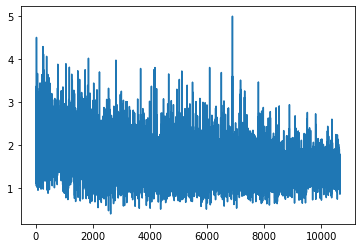

In [17]:
dataset = 'ukiless'
torch.save(netG_A2B.state_dict(), f"weights/{dataset}/netG_A2B.pth")
torch.save(netG_B2A.state_dict(), f"weights/{dataset}/netG_B2A.pth")
torch.save(netD_A.state_dict(), f"weights/{dataset}/netD_A.pth")
torch.save(netD_B.state_dict(), f"weights/{dataset}/netD_B.pth")
plt.plot(g_losses)
plt.show()

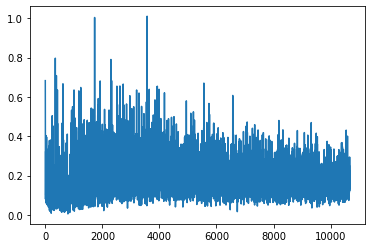

In [18]:
plt.plot(d_losses)
plt.show()

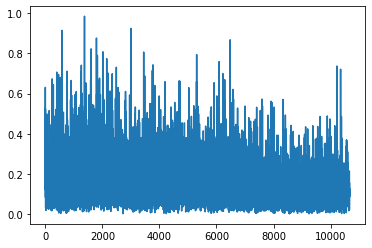

In [19]:
plt.plot(identity_losses)
plt.show()

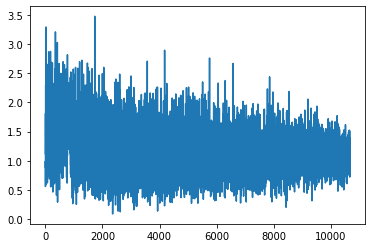

In [20]:
plt.plot(gan_losses)
plt.show()

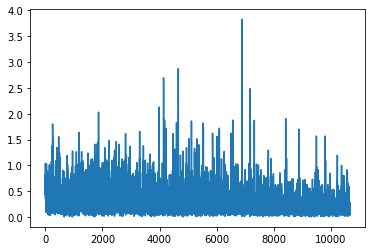

In [21]:
plt.plot(cycle_losses)
plt.show()